# Testing watershed halo finder

Here, we compare the results of our watershed-based halo finder, which works directly on a gridded density field, with the FoF halo finder used by nbodykit, which acts on a particle catalog.

In [1]:
import hickle as hkl
import postEoR.tools as tools
import numpy as np
import matplotlib.pyplot as plt
from hmf import MassFunction

We load in the particle distribution from nbodykit, which has been painted to a gridded density field for use in the watershed halo finder.
1000 particles per cell are used, each with a mass of $97452.59 M_{\odot}$ (to give the field an average density equal to the critical density of the universe).

In [2]:
dens = hkl.load("nbody_dens_no_interlace_40.hkl")

In [3]:
halos = tools.find_halos_watershed(dens, cell_size=40/250, connectivity=1, normalise=False)
hkl.dump(halos, "watershed_halos_overdensNone_conn1.hkl", mode="w")

poo
Optimal overdensity cap used is 8.0
18709
crit dens 5.8160395484597314e-27
min mass of cell before halos 2666151923.991699


In [7]:
hlittle = 67.66 / 100
ws_halos = hkl.load("watershed_halos_overdensNone_conn1.hkl")
nb_halo_mass = hkl.load("halo_masses_nmin6_b0.2.hkl")
nb_halo_pos = hkl.load("halo_positions_nmin6_b0.2.hkl")

nb_halo_pos[nb_halo_pos==250] = 249
print(np.max(nb_halo_pos))

nb_halo_field = np.zeros([250, 250, 250])
print(np.shape(nb_halo_pos))

for i in range(np.shape(nb_halo_pos)[0]):
    coord = nb_halo_pos[i]
    nb_halo_field[coord[0], coord[1], coord[2]] += nb_halo_mass[i]

# normalising to the total mass of our sim
nb_halo_field *= np.sum(ws_halos) / np.sum(nb_halo_field) 

"""nb_halo_field[nb_halo_field < 1e11] = 0
ws_halos[ws_halos < 1e11] = 0"""

"""nb_halo_field[nb_halo_field > 1e13] = 0
ws_halos[ws_halos > 1e13] = 0"""


print(np.count_nonzero(nb_halo_field))
print(np.count_nonzero(nb_halo_mass)) # check how many nb halos have been combined into one due to gridding
print(np.count_nonzero(ws_halos))



249
(21689, 3)
13732
21689
18709


In [5]:
print(np.max(ws_halos))

728064184746.9648


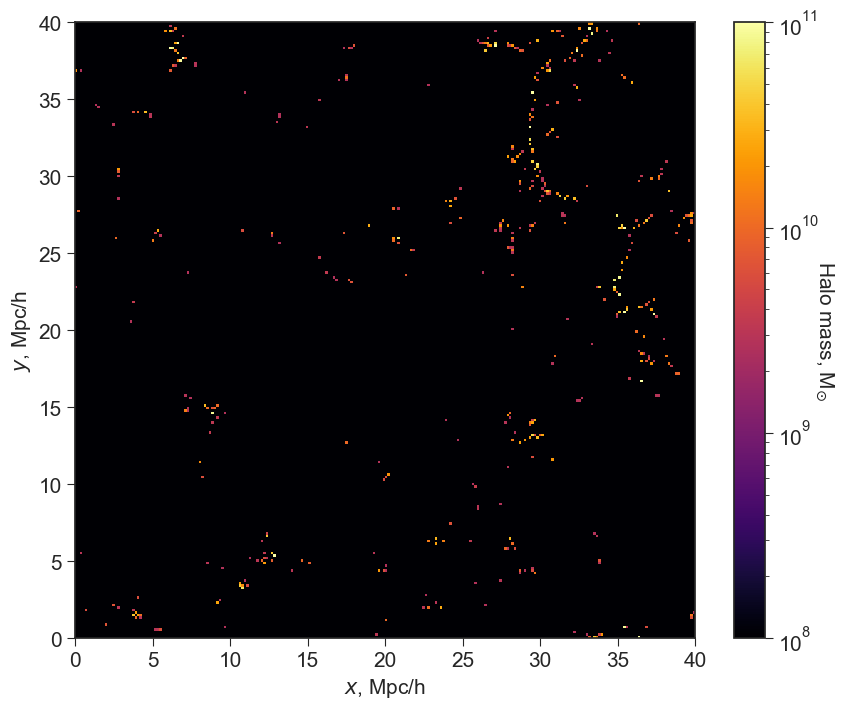

In [6]:
plt.style.use('seaborn-v0_8-ticks')

plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams.update({'font.size': 15})

plt.clf() # clearing any previous plots
plt.rcParams['figure.figsize'] = [13, 6]

# box coordinates
fin_size = 40
dx, dy = 4/25, 4/25
y1, x1 = np.mgrid[slice(dy / 2, fin_size, dy), slice(dx / 2, fin_size, dx)]

# plotting colormaps of overdensity, neutral fraction, brightness temperature
plt.xlabel('$x$, Mpc/h')
plt.ylabel('$y$, Mpc/h')

plt.pcolormesh(x1, y1, ws_halos[:, :, 48]+ws_halos[:, :, 49]+ws_halos[:, :, 50]+ws_halos[:, :, 51]+ws_halos[:, :, 52]+1, vmax=1e11, vmin=1e8, cmap='inferno', norm="log")
#plt.title("Watershed halos, overdens None conn 1, 40/250")
cbar = plt.colorbar()
cbar.set_label("Halo mass, M$_{\odot}$", rotation=270, labelpad = 12)

Now, we plot the nbodykit halos, which have been painted to a mesh for analysis here.
We remove any negative halo values that have arisen from any interlacing and set them to 0, and also convert the field from a halo overdensity to solar masses.

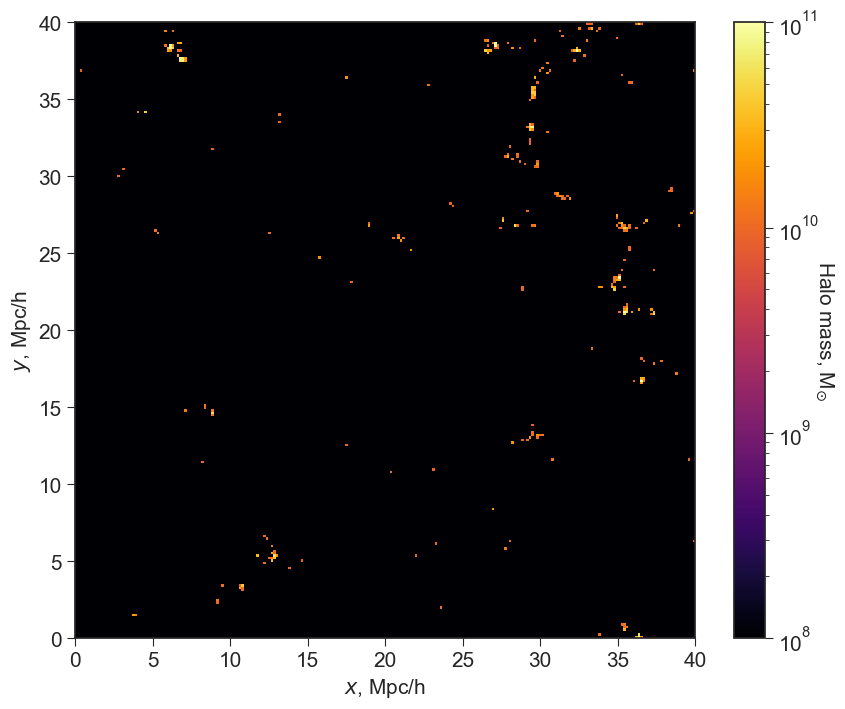

In [7]:
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams.update({'font.size': 15})

plt.clf() # clearing any previous plots
plt.rcParams['figure.figsize'] = [13, 6]

# box coordinates
fin_size = 40
dx, dy = 4/25, 4/25
y1, x1 = np.mgrid[slice(dy / 2, fin_size, dy), slice(dx / 2, fin_size, dx)]

# plotting colormaps of overdensity, neutral fraction, brightness temperature
plt.xlabel('$x$, Mpc/h')
plt.ylabel('$y$, Mpc/h')

plt.pcolormesh(x1, y1, nb_halo_field[:, :, 48]+nb_halo_field[:, :, 49]+nb_halo_field[:, :, 50]+nb_halo_field[:, :, 51]+nb_halo_field[:, :, 52]+1, vmax=1e11, vmin=1e8, cmap='inferno', norm="log")
#plt.title("Watershed halos, overdens None conn 1, 40/250")
cbar = plt.colorbar()
cbar.set_label("Halo mass, M$_{\odot}$", rotation=270, labelpad = 12)


We plot the HMF of the watershed halos and the HMF of the nbodykit halos on the same plot for a direct comparison.

/Users/Rach/opt/anaconda3/envs/fast/lib/python3.11/site-packages/hmf/density_field/transfer_models.py:233: UserWarning: 'extrapolate_with_eh' was not set. Defaulting to True, which is different behaviour than versions <=3.4.4. This warning may be removed in v4.0. Silence it by setting extrapolate_with_eh explicitly.
  warnings.warn(


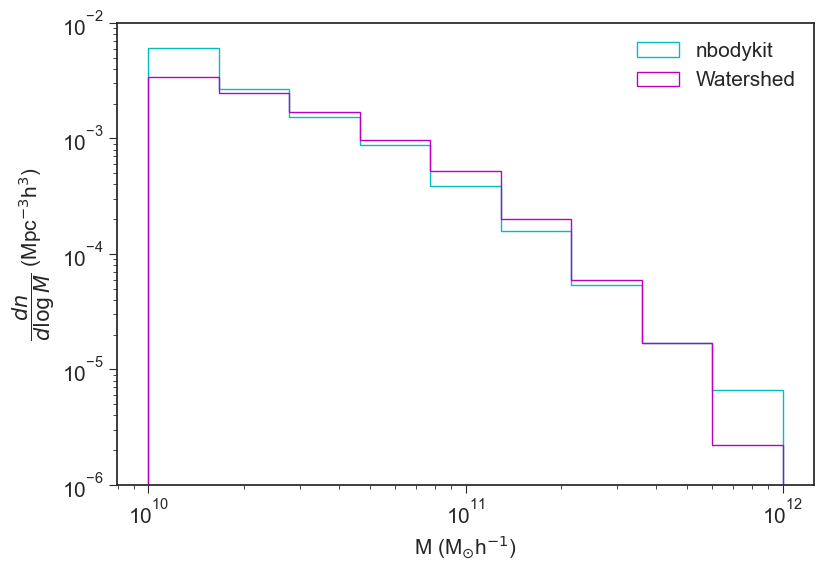

In [8]:
Mmin=10
Mmax=12
box_len=40
OMm = 0.30964144154550644
z = 4
hlittle = 67.66 / 100


bins1 = np.geomspace(10**Mmin, 10**Mmax, 10)
counts, bins = np.histogram(nb_halo_field, bins1)
los_dist = box_len
plt.rcParams['figure.figsize'] = [9, 6]
bins_plot = (bins[1:] + bins[:-1]) / 2
plt.hist(bins_plot, bins, weights=(2 * counts / (np.log(bins[1:]+bins[:-1])*box_len**2*los_dist)), histtype='step', label="nbodykit", color="c")

bins1 = np.geomspace(10**Mmin, 10**Mmax, 10)
counts, bins = np.histogram(ws_halos, bins1)
los_dist = box_len
plt.rcParams['figure.figsize'] = [9, 6]
bins_plot = (bins[1:] + bins[:-1]) / 2
plt.hist(bins_plot, bins, weights=(2 * counts / (np.log(bins[1:]+bins[:-1])*box_len**2*los_dist)), histtype='step', label="Watershed", color="m")


mf1 = MassFunction(Mmin=Mmin-1, Mmax=Mmax+1, z = z,
            cosmo_params={"Om0":OMm}, 
            hmf_model="Watson") 

#plt.plot(mf1.m, mf1.dndm * mf1.m, label="Theoretical HMF", color="tab:green")
#plt.title("HMF comparison full norm")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.ylabel('$\dfrac{dn}{d\log M}$ (Mpc$^{-3} $h$^3$)')
plt.xlabel('M (M$_{\odot} $h$^{-1}$)')
#plt.xlim(10**Mmin, 10**Mmax)
plt.ylim(1e-6, 1e-2)

plt.show()

We plot the PS of the watershed halos and the PS of the nbodykit halos on the same plot for a direct comparison.

Using input bins
Using input bins


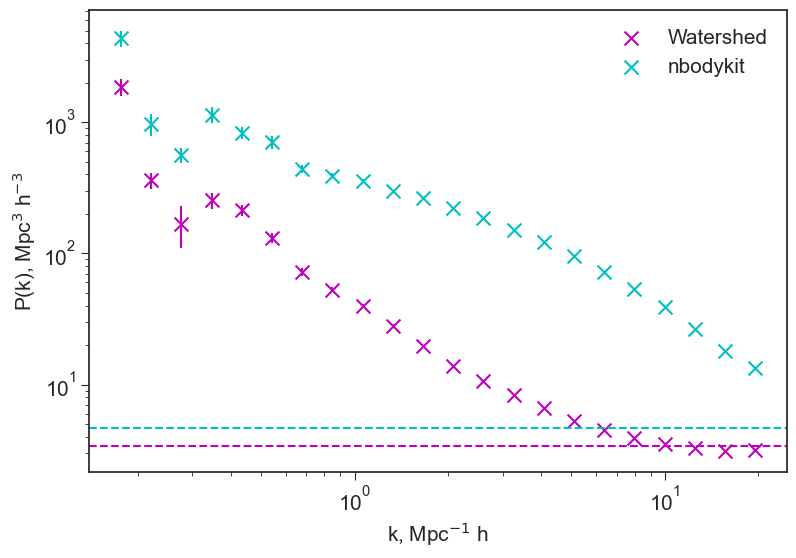

In [9]:
from postEoR.analysis import get_PS

HII_dim = 250
box_len = 40
n = np.size(ws_halos)

ws_sn = box_len**3 / np.count_nonzero(ws_halos) 

nb_sn = box_len**3 / np.count_nonzero(nb_halo_field) # this is fine

ws_halos[ws_halos>0] = 1
ws_halos[ws_halos<0] = 0
"""nb_halo_field[nb_halo_field>0]=1
nb_halo_field[nb_halo_field<0]=0"""

nb_halo_field /=np.mean(nb_halo_field)
ws_halos /= np.mean(ws_halos)

ksx = np.fft.fftfreq(np.shape(ws_halos)[0], (box_len / HII_dim)) * 2 * np.pi # max accessible wavenumber corresponds to 2 * pi
ksy = np.fft.fftfreq(np.shape(ws_halos)[1], (box_len / HII_dim)) * 2 * np.pi
ksz = np.fft.fftfreq(np.shape(ws_halos)[2], (box_len / HII_dim)) * 2 * np.pi
kx, ky, kz = np.meshgrid(ksx, ksy, ksz) # converting to a 3d array
k = (kx**2+ky**2+kz**2)**0.5 # spherical k-values
k = k.reshape(np.size(k)) # converting to 1d array for use in binned_statistic
kbins = np.geomspace(np.min(k[np.nonzero(k)]), np.max(k), 25)

ws_k, ws_ps, ws_err = get_PS(ws_halos, box_len, HII_dim, kbins=kbins) 

n1_k, n1_ps, n1_err = get_PS(nb_halo_field, box_len, HII_dim, kbins=kbins) 


plt.rcParams['figure.figsize'] = [9, 6]
plt.scatter(ws_k, ws_ps, color="m", label="Watershed", marker="x", s=100)
plt.scatter(n1_k, n1_ps, color="c", label="nbodykit", marker="x", s=100)
plt.errorbar(ws_k, ws_ps, ws_err, linestyle="none", color="m")
plt.errorbar(n1_k, n1_ps, n1_err, linestyle="none", color="c")
plt.axhline(y = ws_sn, color = 'm', linestyle = '--') 
plt.axhline(y = nb_sn, color = 'c', linestyle = '--') 


plt.yscale("log")
plt.xscale("log")
plt.ylabel("P(k), Mpc$^3$ h$^{-3}$")
plt.xlabel("k, Mpc$^{-1}$ h")
plt.legend()
#plt.title("PS comparison, clustering")
plt.show()